In [2]:
import os 
import tarfile
from six.moves import urllib

In [3]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"

#funtion to access data file
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, 'housing.tgz')
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [4]:
fetch_housing_data()

In [5]:
import pandas as pd
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [6]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [7]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [8]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [9]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


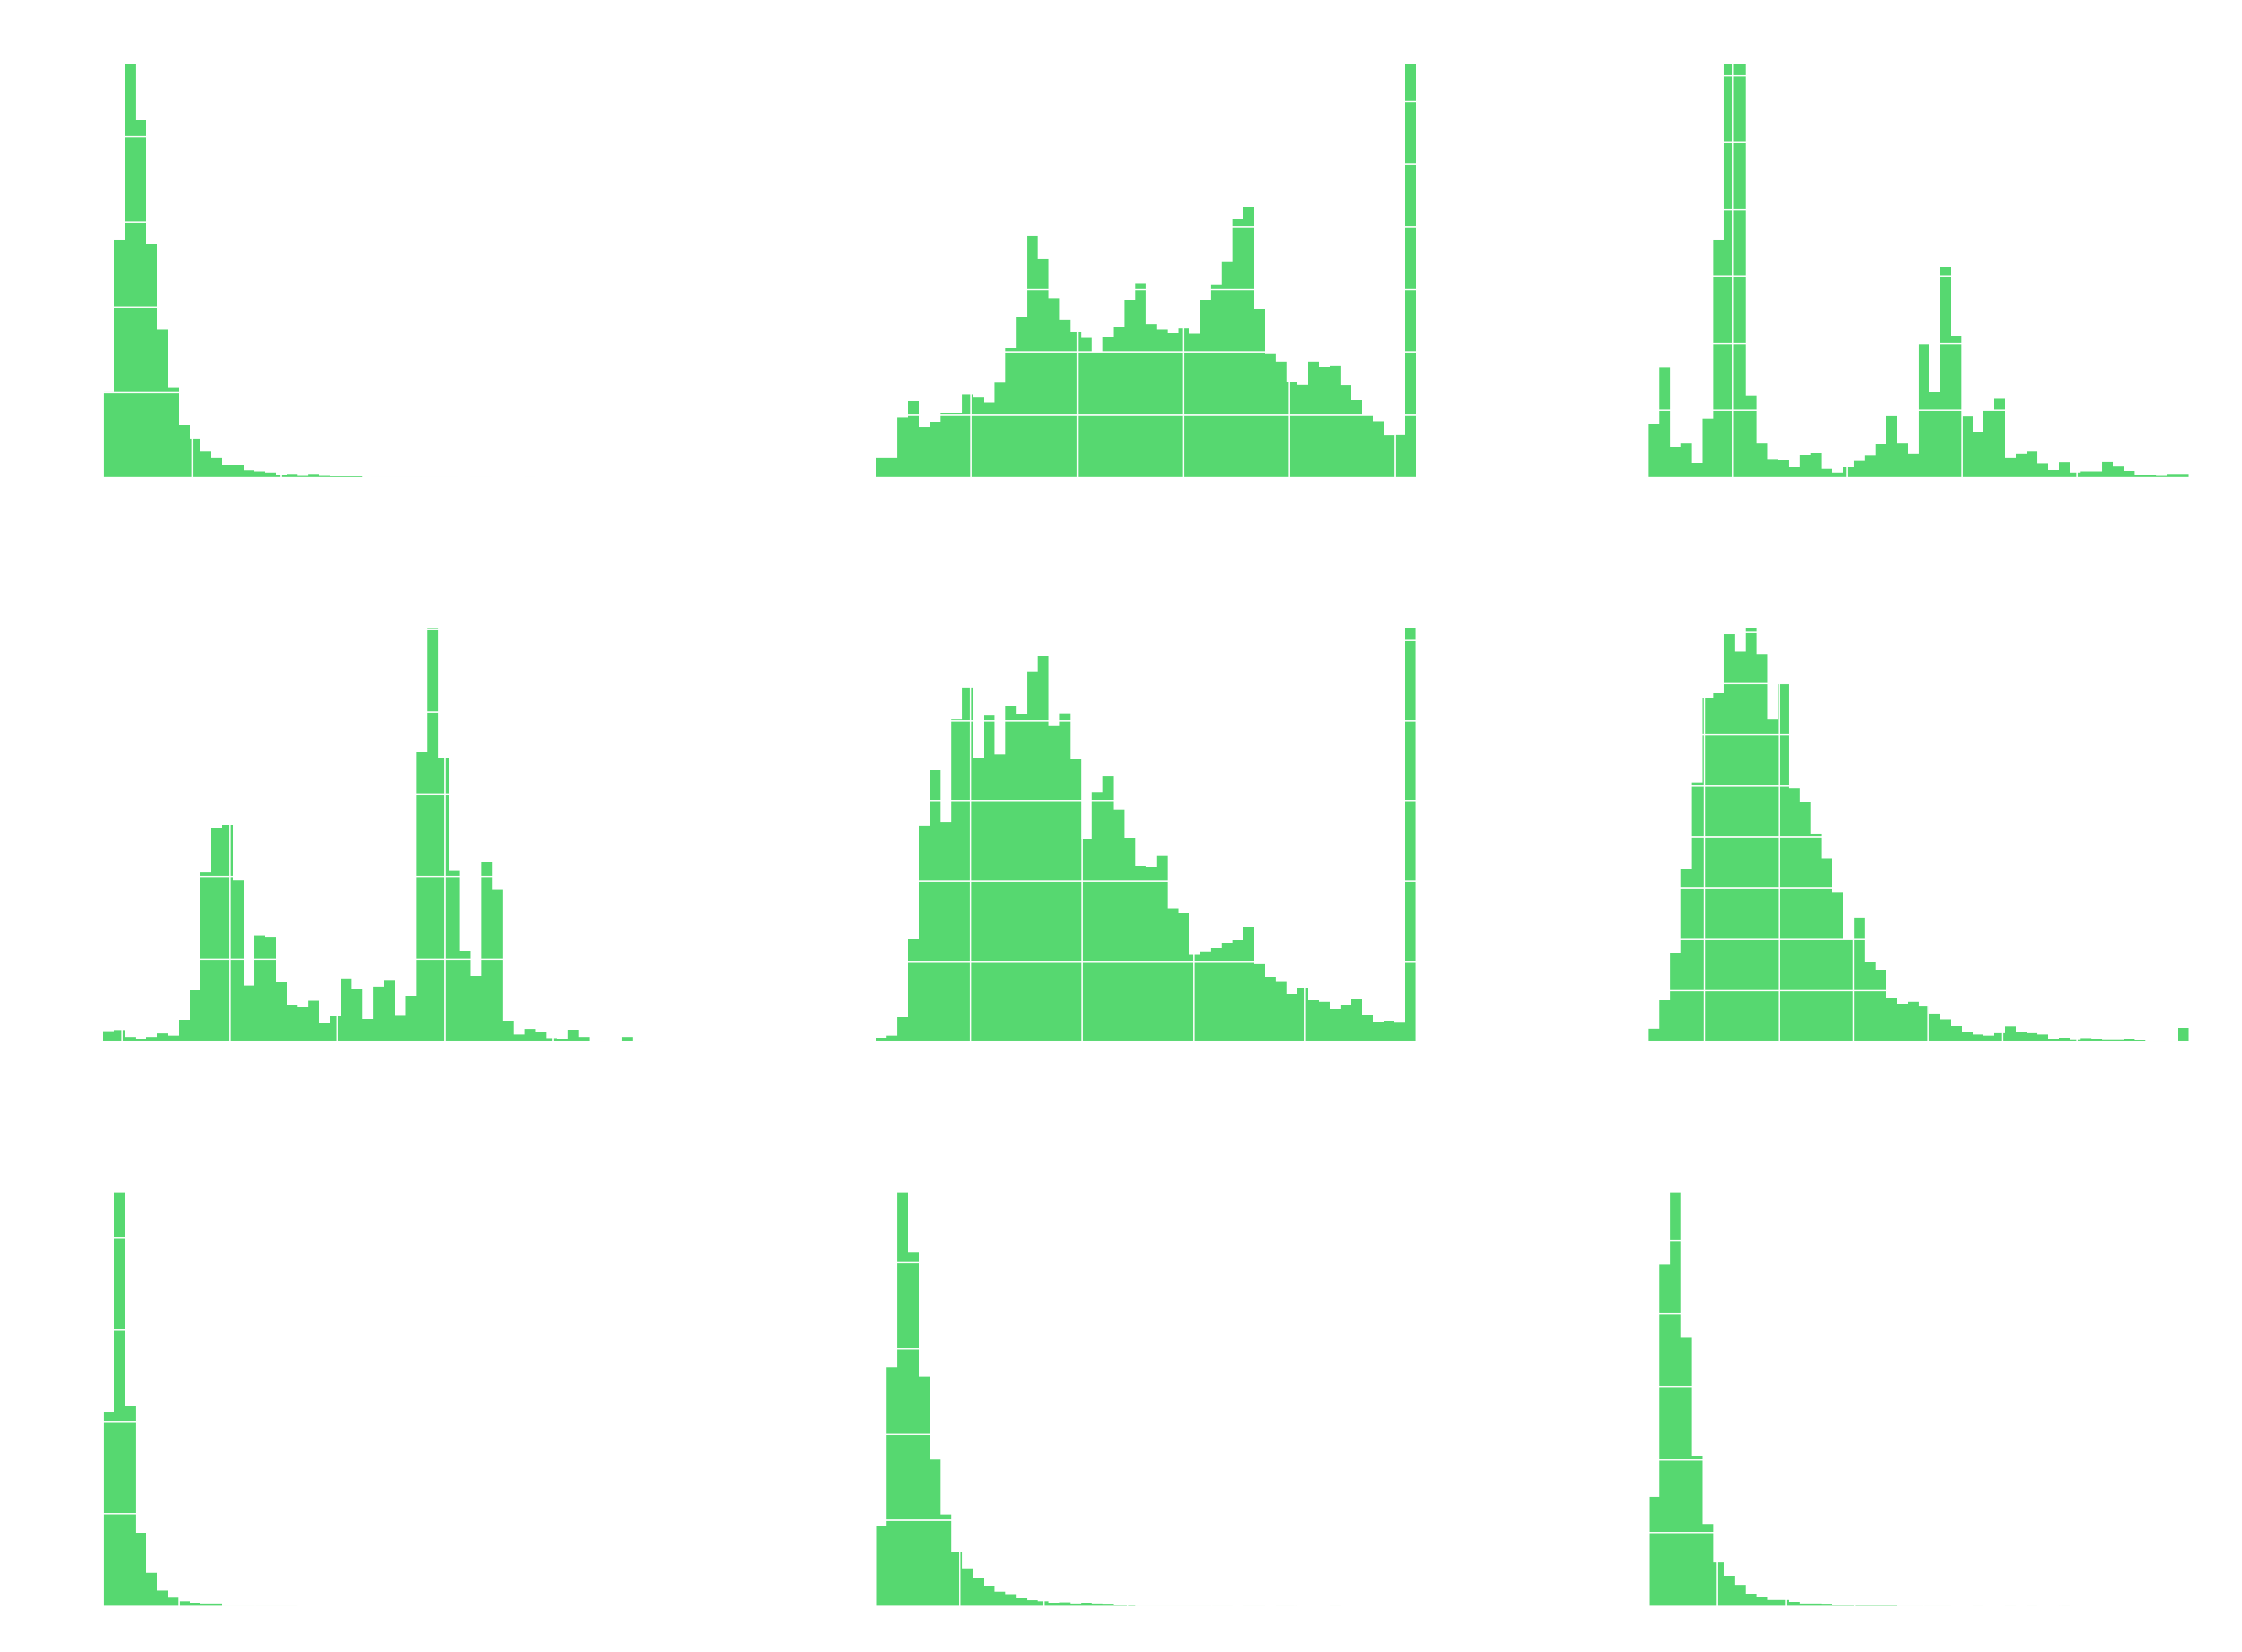

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

#### Splitting the data -> test_set (stratified)

In [11]:
#Splitting the data
import numpy as np

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [12]:
train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


In [13]:
# Function able to preserve the test_set, not mixing with train_set
import hashlib

def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

#### Figuring out ways to insert Ids

In [14]:
# adds an 'index' column
housing_with_id = housing.reset_index() 
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

# Using distintic data to make an id;
housing_with_id['id'] = housing['longitude'] * 1000 + housing['latitude']
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [15]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [16]:
# reducing the number of median_income categories;
housing['income_cat'] = np.ceil(housing['median_income'] / 1.5)
housing['income_cat'].where(housing['income_cat'] < 5, 5.0, inplace=True)


In [17]:
# stratified sampling: the population is divided into homogeneous subgroups called strata
# however it is important to make sure that the data randomly generated is statified based on the real
# data
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [18]:
housing['income_cat'].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [19]:
strat_test_set['income_cat'].value_counts() / len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

In [20]:
def income_cat_proportions(data):
    return data['income_cat'].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set)
}).sort_index()

compare_props['Rand. %error'] = 100 * compare_props['Random'] / compare_props['Overall'] - 100
compare_props['Strat. %error'] = 100 * compare_props['Stratified'] / compare_props['Overall'] - 100

compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1.0,0.039826,0.039729,0.040213,0.973236,-0.243309
2.0,0.318847,0.318798,0.324370,1.732260,-0.015195
3.0,0.350581,0.350533,0.358527,2.266446,-0.013820
4.0,0.176308,0.176357,0.167393,-5.056334,0.027480
5.0,0.114438,0.114583,0.109496,-4.318374,0.127011


In [21]:
# Remove the income_cat attribute
for set in (strat_train_set, strat_test_set):
    set.drop(['income_cat'], axis=1, inplace=True)

### Discover and Visualize Data

In [22]:
housing = strat_train_set.copy()

**Visualizing Geographical Data**


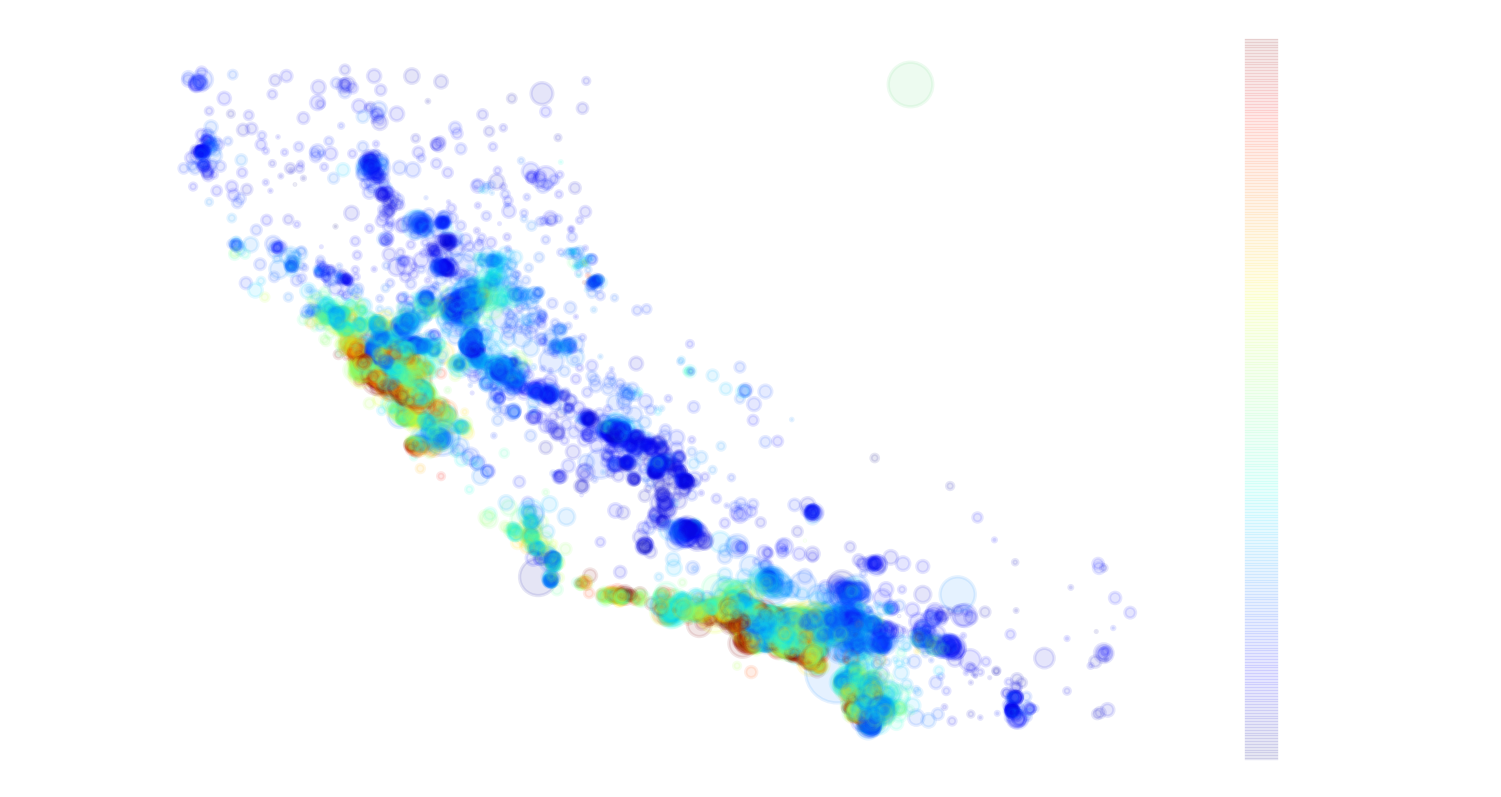

In [23]:
# The radius of each circle represents the district’s population (option s),
# and the color represents the price (option c).
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1, 
             s=housing['population']/100, label='population',
             c="median_house_value", cmap=plt.get_cmap('jet'), colorbar=True)
plt.legend()

In [24]:
# prices closest to the ocean are more expensive

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


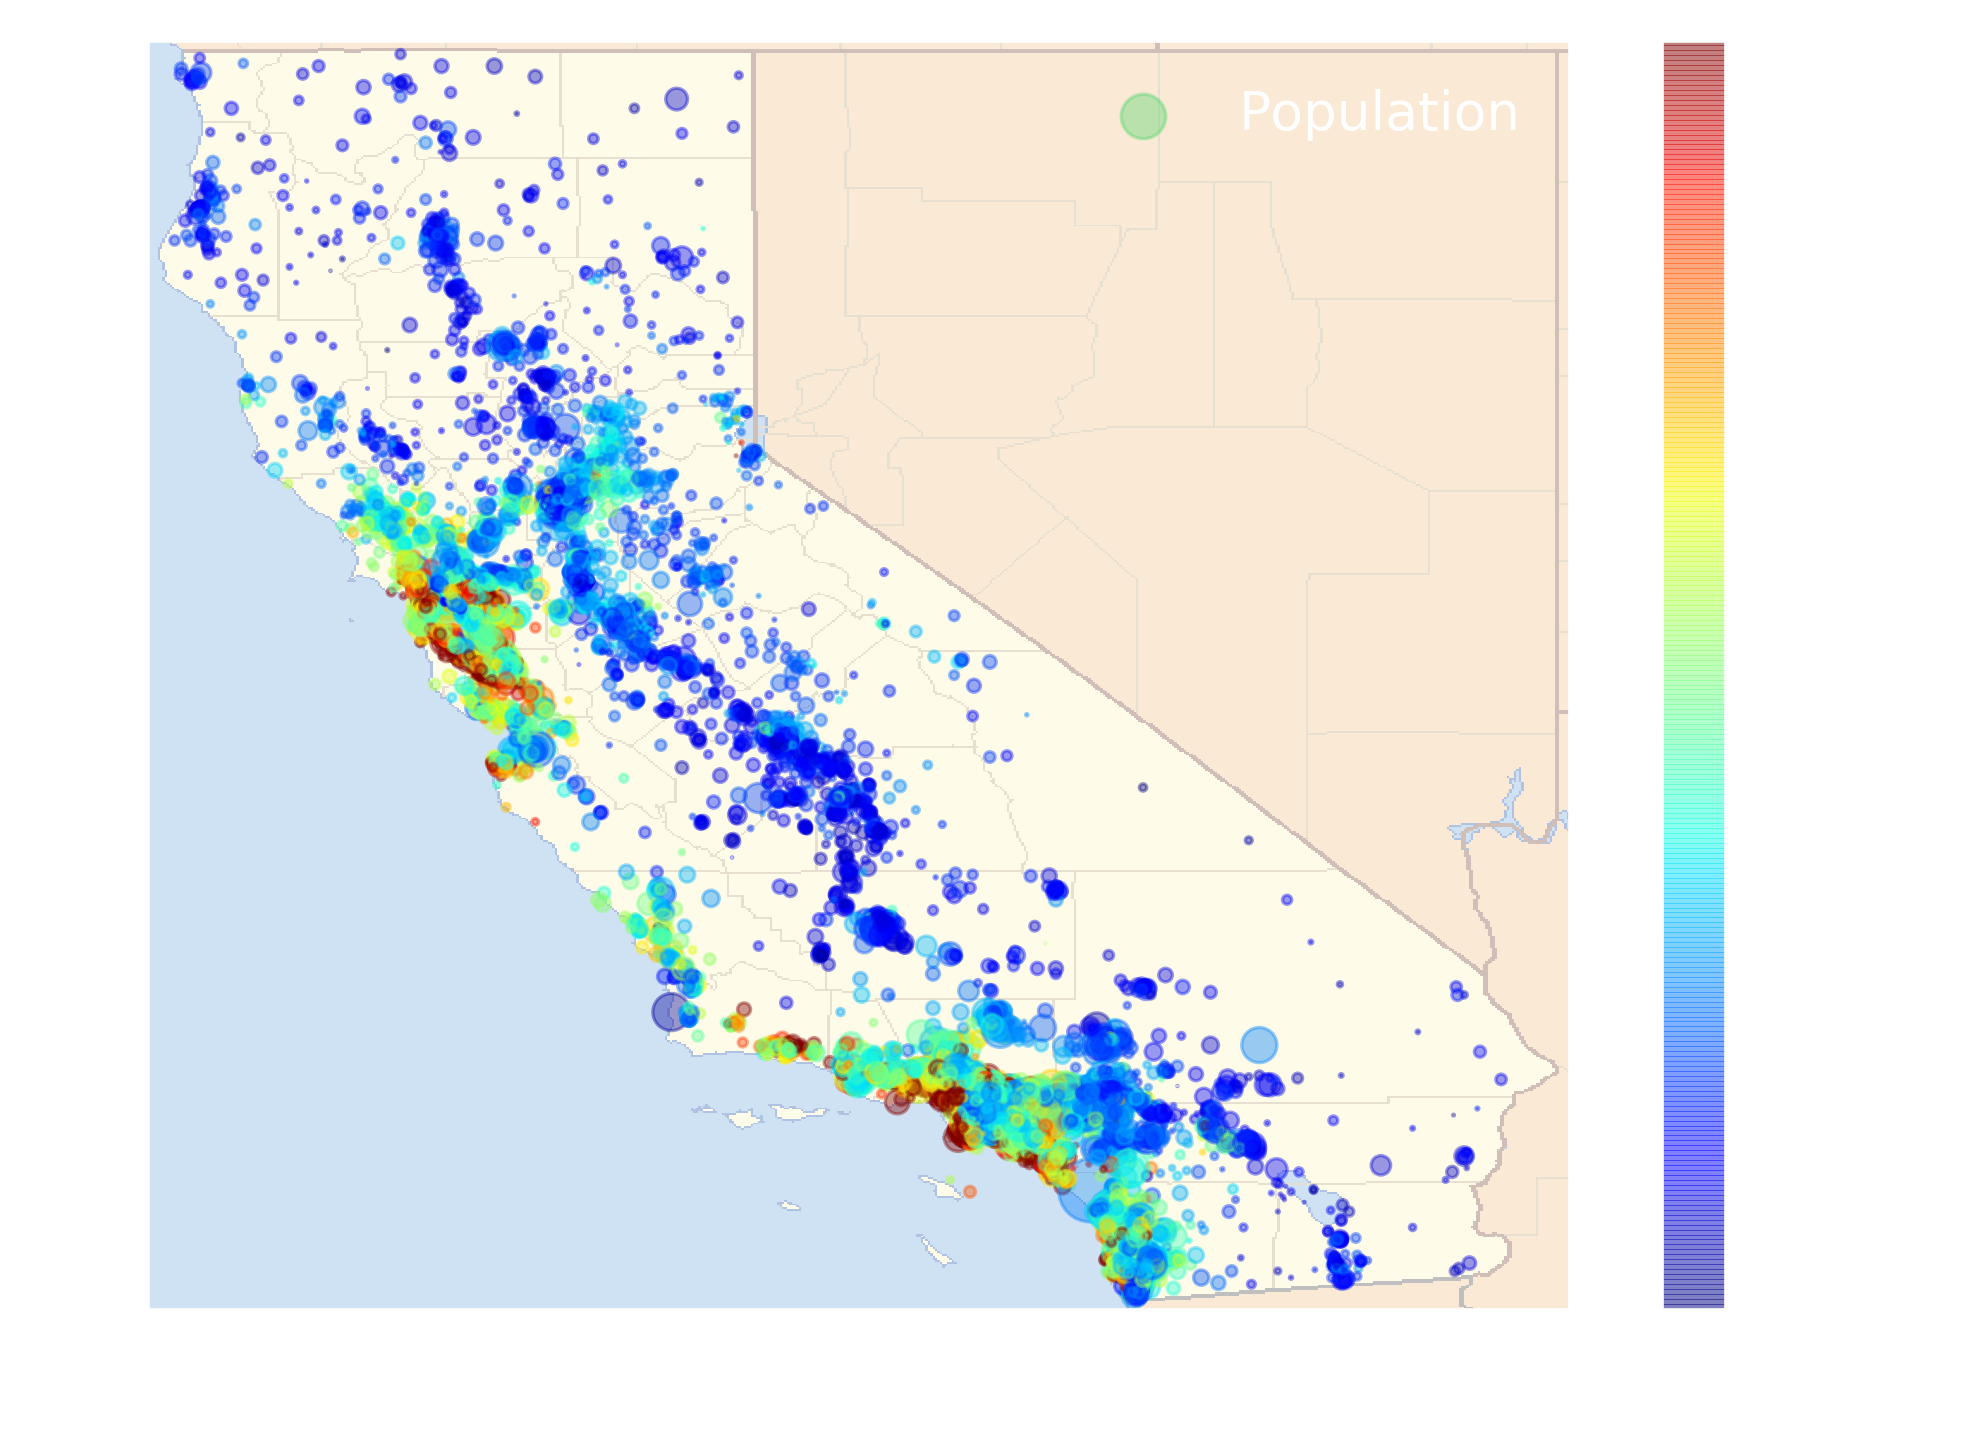

In [25]:
import matplotlib.image as mpimg
california_img=mpimg.imread('./images/california.png')
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=housing['population']/100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
plt.show()

**Looking for correlations**

In [26]:
# standard correlation coefficient (also called Pearson’s r)
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


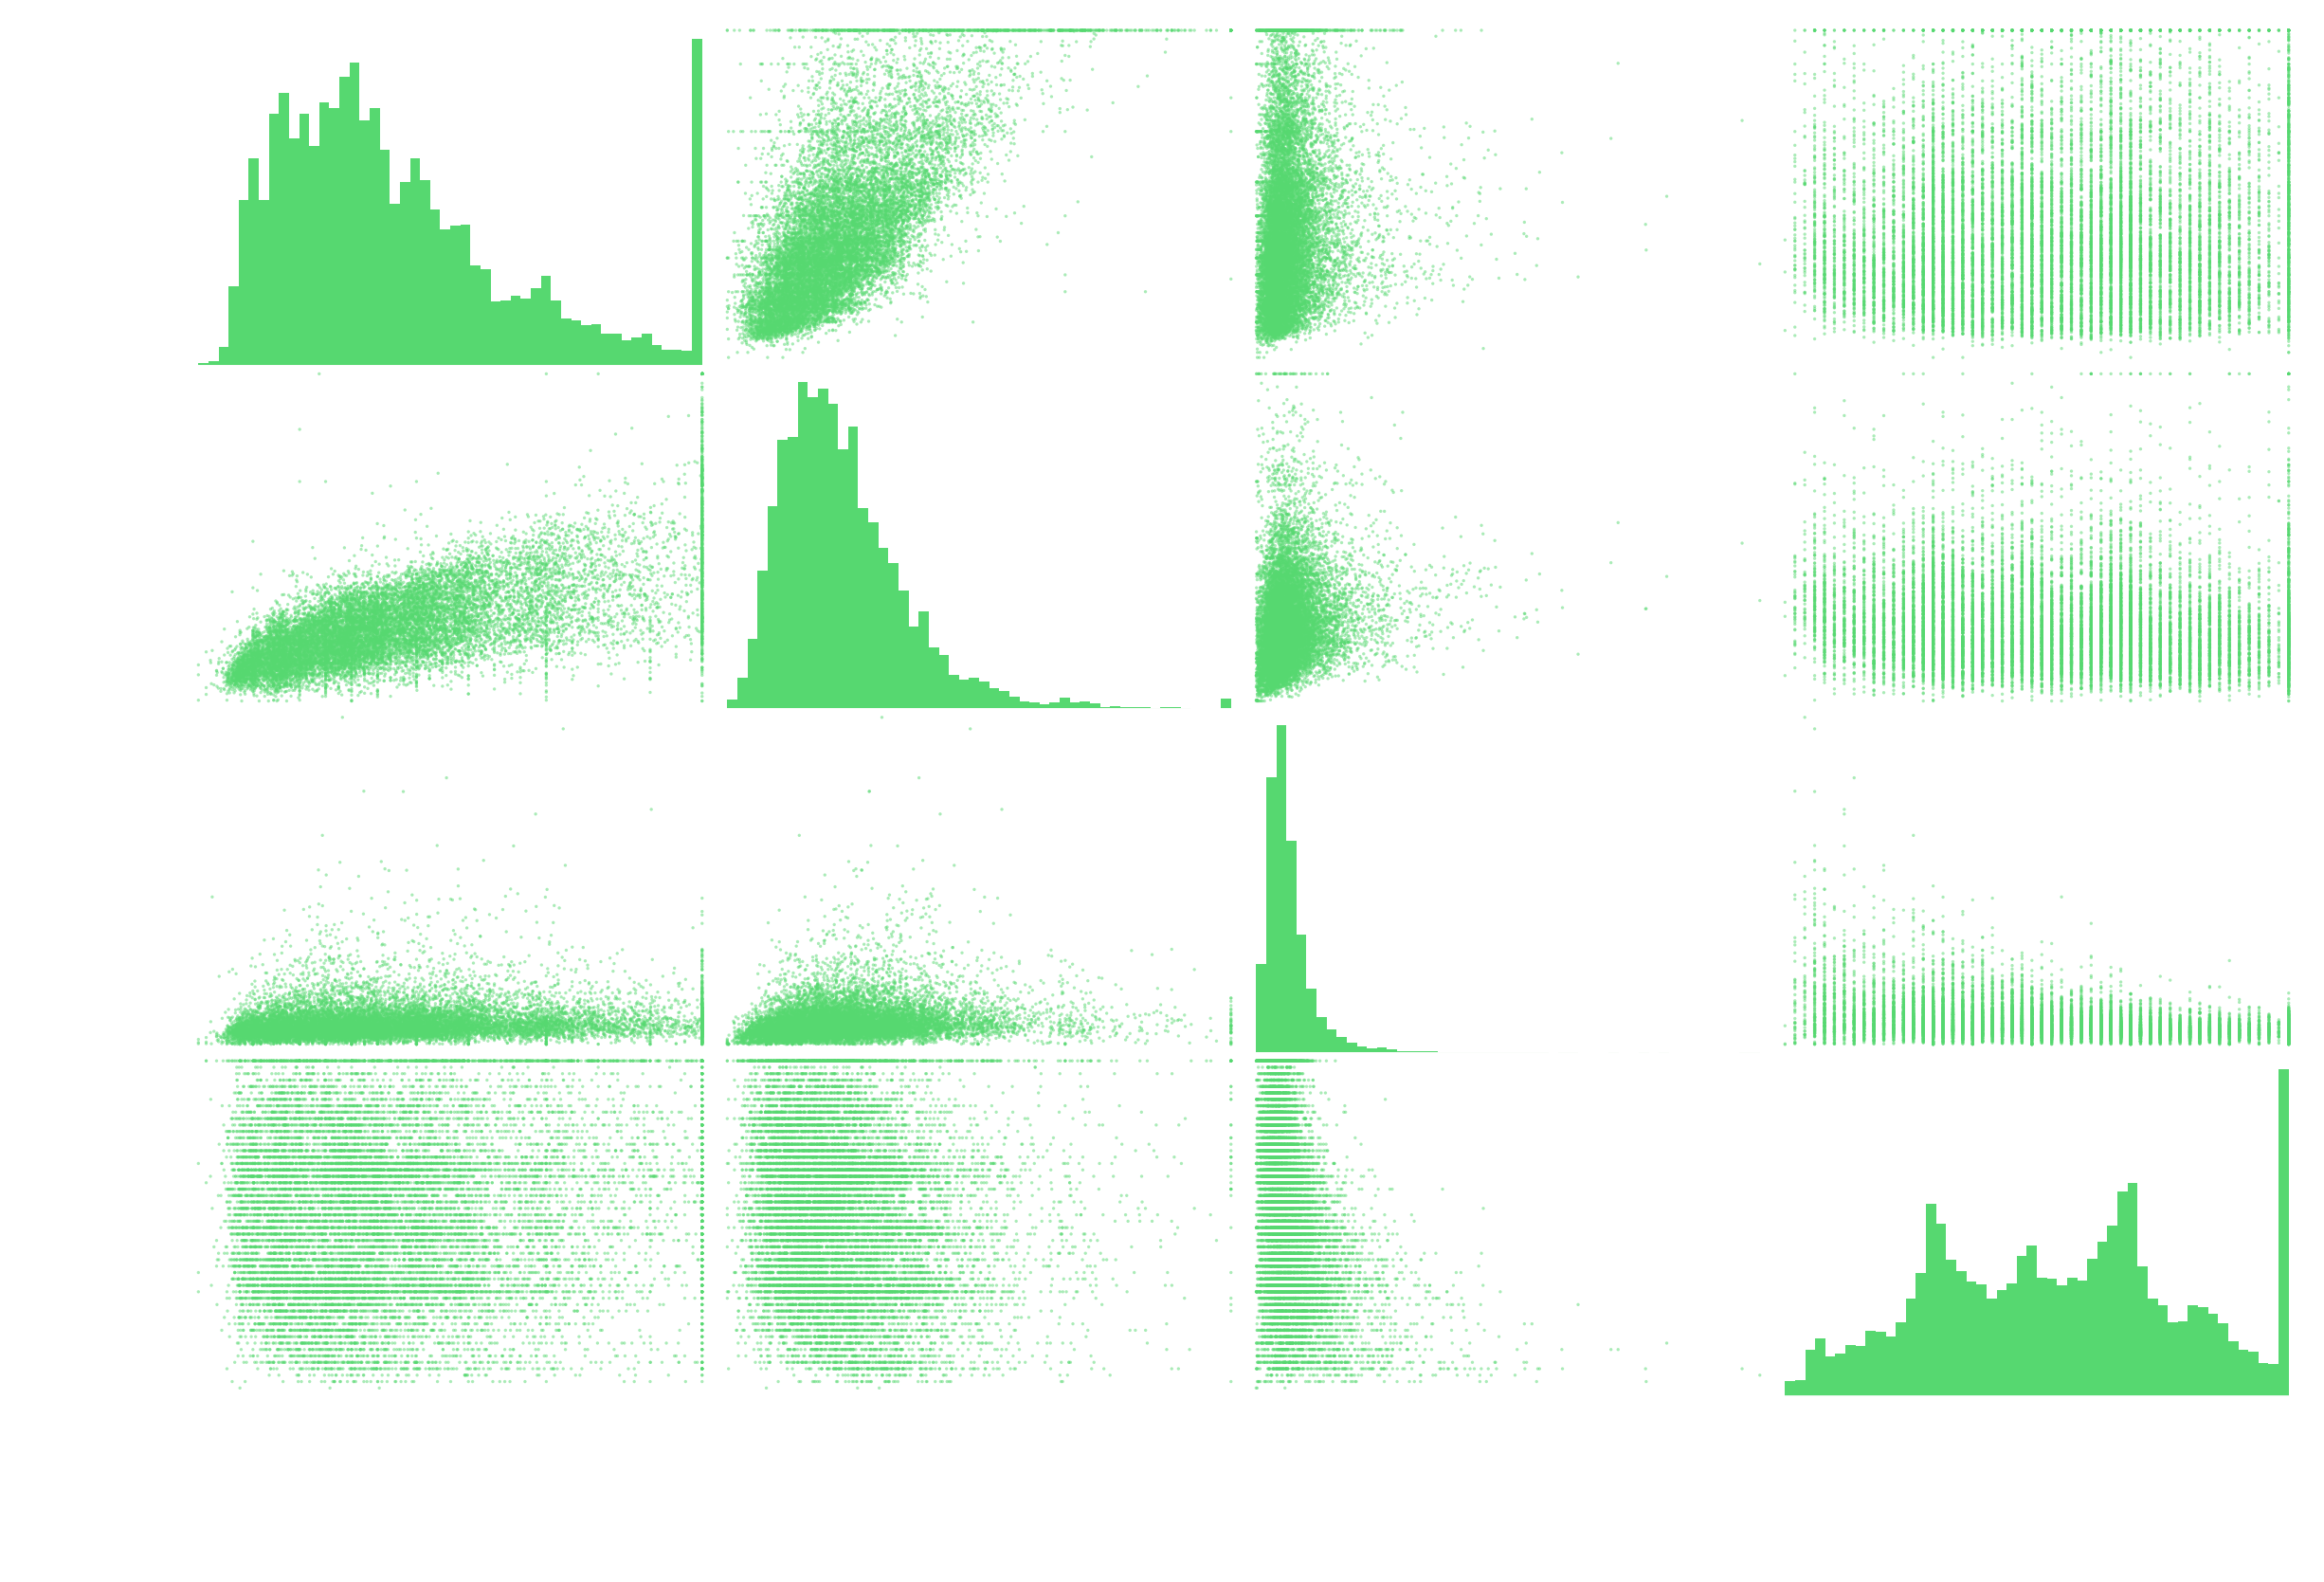

In [27]:
from pandas.plotting import scatter_matrix

attributes = ['median_house_value', "median_income", 'total_rooms', 'housing_median_age']
scatter_matrix(housing[attributes], figsize=(12, 8));

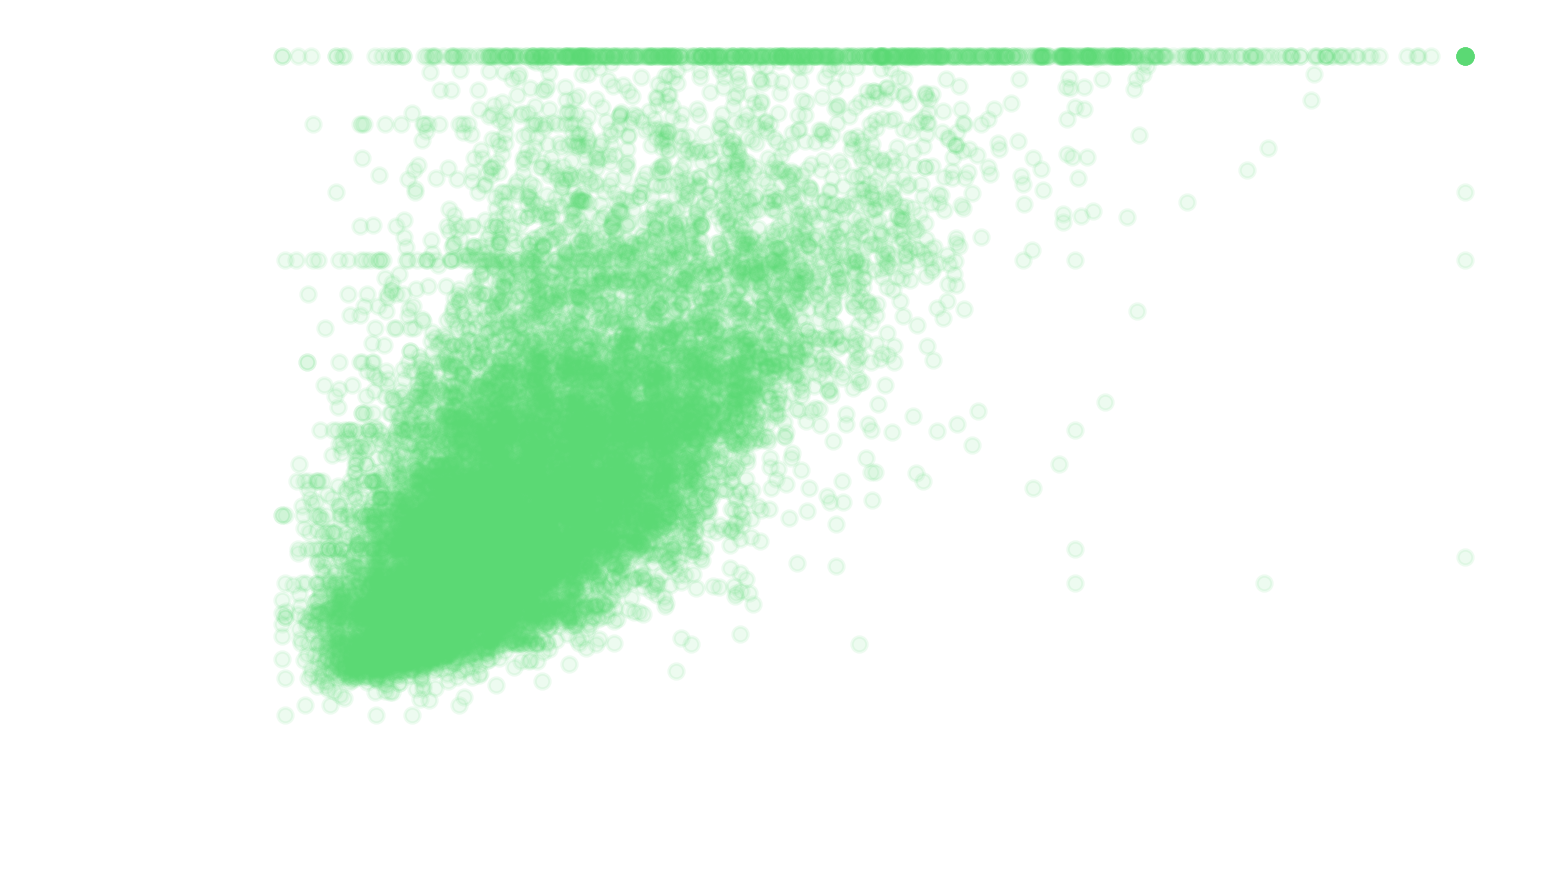

In [28]:
# The most promising attribute to predict the median house value is the median income
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1);

In [29]:
# a horizontal line around $450,000, another around $350,000, perhaps one around $280,000,
# and a few more below that. You may want to try removing the corresponding districts to
# prevent your algorithms from learning to reproduce these data quirks.

In [30]:
# identified a few data quirks that you may want to clean up
# before feeding the data to a Machine Learning algorithm, and you found interesting
# correlations between attributes, in particular with the target attribute. You also
# noticed that some attributes have a tail-heavy distribution, so you may want to trans‐
# form them (e.g., by computing their logarithm).

In [31]:
housing['rooms_per_household'] = housing['total_rooms']/housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms']/housing['total_rooms']
housing['population_per_household'] = housing['population']/housing['households']

In [32]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

##### Prepare the Data for Machine Learning Algorithms

In [33]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

In [34]:
# Dealing with missing values
    # housing.dropna(subset=['total_bedrooms'])
    # housing.drop('total_bedrooms', axis=1)
    # median = housing['total_bedrooms'].median()
    # housing['total_bedrooms'].fillna(median)

In [35]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
# only works in number columns
housing_num = housing.drop('ocean_proximity', axis=1)
imputer.fit(housing_num)
imputer.statistics_


array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [36]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [37]:
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns)


**Handling Text and Categorical Attributes**

In [38]:
# transforming categories into number
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
housing_cat = housing['ocean_proximity']
housing_cat_encoded = encoder.fit_transform(housing_cat)
housing_cat_encoded

array([0, 0, 4, ..., 1, 0, 3])

In [39]:
print(encoder.classes_)

['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


In [40]:
# That gave us a weird classification like: OCEAN is 0 and NEAR OCEAN is 4; the algorithm can find that
# weird, to fix that is better use OneHotEncoder solution from sklearn
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
# fit_transform() expects a 2D array, but housing_cat_encoded is a 1D array
# 18 NumPy’s reshape() function allows one dimension to be –1, which means “unspecified”: the value is inferred
# from the length of the array and the remaining dimensions.
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [41]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [42]:
# We can apply both transformations (from text categories to integer categories,
# then from integer categories to one-hot vectors
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer(sparse_output=True)
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.int32'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [48]:
# building our own transformer
from sklearn.base import BaseEstimator, TransformerMixin
# get the right column indices: safer than hard-coding indices 3, 4, 5, 6
rooms_ix, bedrooms_ix, population_ix, household_ix = [
    list(housing.columns).index(col)
    for col in ("total_rooms", "total_bedrooms", "population", "households")]

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kwargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)



In [61]:
# Alternative to use sklearn transformer
from sklearn.preprocessing import FunctionTransformer

def add_extra_features(X, add_bedrooms_per_room=True):
    rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
    population_per_household = X[:, population_ix] / X[:, household_ix]
    if add_bedrooms_per_room:
        bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
        return np.c_[X, rooms_per_household, population_per_household,
                     bedrooms_per_room]
    else:
        return np.c_[X, rooms_per_household, population_per_household]

attr_adder = FunctionTransformer(add_extra_features, validate=False,
                                 kw_args={"add_bedrooms_per_room": False})
housing_extra_attribs = attr_adder.fit_transform(housing.values)

In [62]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
17606,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
18632,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
14650,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3230,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
3555,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785


**Transformation Pipelines**

In [64]:
# All but the last estimator must be transformers (i.e., they must have a fit_transform() method)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")), # everyone that is empty goes to the median
    ('attribs_adder', CombinedAttributesAdder()), # adding new columns based on columns we have
    ('std_scaler', StandardScaler()) # defining a "standarization based on Scaler"
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

In [100]:
# Multiple pipelines
try:
    from sklearn.compose import ColumnTransformer
except ImportError:
    from future_encoders import ColumnTransformer # Scikit-Learn < 0.20

num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', FunctionTransformer(add_extra_features, validate=False)),
        ('std_scaler', StandardScaler()),
    ])

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs)
])

housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared.shape

(16512, 16)

**Select and Train a Model**

**Training and Evaluating on the Training Set**

In [101]:
# You framed the problem, you got the data and explored it, you sampled a
# training set and a test set, and you wrote transformation pipelines to clean up and
# prepare your data for Machine Learning algorithms automatically. You are now ready
# to select and train a Machine Learning model.
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels) # training set

#training the model in some small instances
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print('Predictions:\t', lin_reg.predict(some_data_prepared))
print('Labels:\t\t', list(some_labels))

Predictions:	 [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]
Labels:		 [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


**Measuring performance**

In [102]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848923

In [120]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

49439.89599001897

In [103]:
# This is an example of a model underfitting
# the training data. When this happens it can mean that the features do not provide
# enough information to make good predictions, or that the model is not powerful
# enough

In [134]:
# DecisionTreeRegressor. This is a powerful model, capable of finding complex nonlinear
# relationships in the data
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [135]:
housing_predicitons = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

68628.19819848923

**Fine-tune your model**

you need to use part of the training set for train‐
ing, and part for model validation

In [136]:
from sklearn.model_selection import cross_val_score

tree_scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                        scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)

def display_scores(scores):
    print("Scores: ", scores)
    print("Mean: ", scores.mean())
    print("Standard deviation: ", scores.std())

display_scores(tree_rmse_scores)


Scores:  [70194.33680785 66855.16363941 72432.58244769 70758.73896782
 71115.88230639 75585.14172901 70262.86139133 70273.6325285
 75366.87952553 71231.65726027]
Mean:  71407.68766037929
Standard deviation:  2439.4345041191004


In [137]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                        scoring='neg_mean_squared_error', cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores:  [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean:  69052.46136345083
Standard deviation:  2731.674001798349


**Building a model on top of many other models is called Ensemble Learning**

In [140]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=10, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [139]:
housing_predicitons = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

68628.19819848923

In [147]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                        scoring='neg_mean_squared_error', cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores:  [51646.44545909 48940.60114882 53050.86323649 54408.98730149
 50922.14870785 56482.50703987 51864.52025526 49760.85037653
 55434.21627933 53326.10093303]
Mean:  52583.72407377466
Standard deviation:  2298.353351147122


In [143]:
# Possible solutions for overfitting are
# to simplify the model, regularize it, or get a lot more training data.
# The goal is to shortlist a few two to five promising models.


In [148]:
pd.Series(np.sqrt(-forest_scores)).describe()

count       10.000000
mean     52583.724074
std       2422.677153
min      48940.601149
25%      51103.222896
50%      52457.691746
75%      54138.265709
max      56482.507040
dtype: float64

In [149]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

111094.6308539982

**Saving Models**

In [144]:
# from sklearn.externals import joblib
# joblib.dump(my_model, "my_model.pkl")
# # and later...
# my_model_loaded = joblib.load("my_model.pkl")

**Fine Tune Your Model**

In [151]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3,10,30], 'max_features': [2,4,6,8]},
    {'bootstrap': [False], 'n_estimators': [3,10], 'max_features': [2,3,4]}
]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [152]:
 grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [153]:
 grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=8, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [154]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

65061.129906210845 {'max_features': 2, 'n_estimators': 3}
55612.035321260664 {'max_features': 2, 'n_estimators': 10}
52978.22693678844 {'max_features': 2, 'n_estimators': 30}
61027.66112106065 {'max_features': 4, 'n_estimators': 3}
52373.25603712493 {'max_features': 4, 'n_estimators': 10}
50577.780700991476 {'max_features': 4, 'n_estimators': 30}
58899.140988738836 {'max_features': 6, 'n_estimators': 3}
52087.864581394126 {'max_features': 6, 'n_estimators': 10}
50122.9703839691 {'max_features': 6, 'n_estimators': 30}
58941.04847497509 {'max_features': 8, 'n_estimators': 3}
52449.488494445235 {'max_features': 8, 'n_estimators': 10}
49838.3618531027 {'max_features': 8, 'n_estimators': 30}
63443.7157787633 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
53994.973850774215 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59844.363274301686 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52534.515600344545 {'bootstrap': False, 'max_features': 3, 'n_estimator

In [169]:

pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.074409,0.003138,0.003390,0.000487,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-3.922396e+09,-4.637168e+09,-3.983120e+09,-4.269038e+09,-4.353030e+09,-4.232951e+09,2.599896e+08,18
1,0.247955,0.016518,0.010570,0.000480,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-2.967130e+09,-3.164697e+09,-3.170026e+09,-2.954775e+09,-3.206864e+09,-3.092698e+09,1.086161e+08,11
2,0.714747,0.009974,0.029172,0.001478,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-2.634636e+09,-2.938324e+09,-2.906386e+09,-2.683083e+09,-2.871033e+09,-2.806693e+09,1.235216e+08,9
3,0.113771,0.005094,0.003796,0.000402,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-3.612109e+09,-3.703797e+09,-3.966523e+09,-3.650396e+09,-3.689051e+09,-3.724375e+09,1.252066e+08,16
4,0.373346,0.007590,0.009613,0.000512,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-2.599008e+09,-2.833348e+09,-2.983174e+09,-2.528155e+09,-2.771105e+09,-2.742958e+09,1.634188e+08,6
5,1.110107,0.010480,0.029317,0.001754,4,30,NaN,"{'max_features': 4, 'n_estimators': 30}",-2.480122e+09,-2.635519e+09,-2.662593e+09,-2.368630e+09,-2.643696e+09,-2.558112e+09,1.150815e+08,3
6,0.169611,0.008649,0.004398,0.001008,6,3,NaN,"{'max_features': 6, 'n_estimators': 3}",-3.156701e+09,-3.815762e+09,-3.546724e+09,-3.236809e+09,-3.589548e+09,-3.469109e+09,2.417685e+08,13
7,0.541210,0.040968,0.011165,0.001169,6,10,NaN,"{'max_features': 6, 'n_estimators': 10}",-2.576421e+09,-2.727216e+09,-2.904606e+09,-2.605258e+09,-2.752227e+09,-2.713146e+09,1.172314e+08,5
8,1.562883,0.034239,0.030917,0.002521,6,30,NaN,"{'max_features': 6, 'n_estimators': 30}",-2.353213e+09,-2.572505e+09,-2.577373e+09,-2.352450e+09,-2.706020e+09,-2.512312e+09,1.387423e+08,2
9,0.200015,0.003865,0.003993,0.000004,8,3,NaN,"{'max_features': 8, 'n_estimators': 3}",-3.428271e+09,-3.459399e+09,-3.633823e+09,-3.403139e+09,-3.445605e+09,-3.474047e+09,8.206734e+07,14


**Feature Importance**

**With this information, you may want to try dropping some of the less useful features**

In [155]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.09491874e-02, 6.76053601e-02, 4.53423478e-02, 1.52204429e-02,
       1.43321715e-02, 1.39173115e-02, 1.44071761e-02, 3.75851777e-01,
       4.64082532e-02, 1.12795655e-01, 5.49949347e-02, 6.77856718e-03,
       1.56461923e-01, 6.97539308e-05, 1.71439253e-03, 3.15074647e-03])

In [159]:
extra_attribs = ["rooms_per_household", 'pop_per_household', 'bedrooms_per_room']
cat_one_hot_attribs = list(encoder.classes_)
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3758517768106295, 'median_income'),
 (0.1564619225304227, 'INLAND'),
 (0.11279565527825669, 'pop_per_household'),
 (0.07094918736798217, 'longitude'),
 (0.06760536013570752, 'latitude'),
 (0.05499493468447889, 'bedrooms_per_room'),
 (0.046408253227989596, 'rooms_per_household'),
 (0.045342347822368186, 'housing_median_age'),
 (0.015220442908613128, 'total_rooms'),
 (0.014407176067047316, 'households'),
 (0.01433217152906905, 'total_bedrooms'),
 (0.013917311525158762, 'population'),
 (0.006778567177936494, '<1H OCEAN'),
 (0.003150746473157014, 'NEAR OCEAN'),
 (0.0017143925303866807, 'NEAR BAY'),
 (6.975393079630948e-05, 'ISLAND')]

#### Evaluate the Model

In [165]:
grid_search.best_estimator_ # best model

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=8, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [168]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value'].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

47703.93288249644

In [ ]:
# The performance will usually be slightly worse than what you measured using crossvalidation
# if you did a lot of hyperparameter tuning (because your system ends up
# fine-tuned to perform well on the validation data, and will likely not perform as well
# on unknown datasets)

**“the median income is the number one predictor of housing prices”**

In [ ]:
# As you can see, much of the work is in the data preparation step, building monitoring
# tools, setting up human evaluation pipelines, and automating regular model training

In [173]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
    'n_estimators': randint(low=1, high=200),
    'max_features': randint(low=1, high=8)
}

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs, 
                                n_iter=10, cv=5, scoring='neg_mean_squared_error',
                                random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [174]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)



49150.70756927707 {'max_features': 7, 'n_estimators': 180}
51389.889203389284 {'max_features': 5, 'n_estimators': 15}
50796.155224308866 {'max_features': 3, 'n_estimators': 72}
50835.13360315349 {'max_features': 5, 'n_estimators': 21}
49280.9449827171 {'max_features': 7, 'n_estimators': 122}
50774.90662363929 {'max_features': 3, 'n_estimators': 75}
50682.78888164288 {'max_features': 3, 'n_estimators': 88}
49608.99608105296 {'max_features': 5, 'n_estimators': 100}
50473.61930350219 {'max_features': 3, 'n_estimators': 150}
64429.84143294435 {'max_features': 5, 'n_estimators': 2}


In [175]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.09491874e-02, 6.76053601e-02, 4.53423478e-02, 1.52204429e-02,
       1.43321715e-02, 1.39173115e-02, 1.44071761e-02, 3.75851777e-01,
       4.64082532e-02, 1.12795655e-01, 5.49949347e-02, 6.77856718e-03,
       1.56461923e-01, 6.97539308e-05, 1.71439253e-03, 3.15074647e-03])

In [179]:
extra_attribs = ['rooms_per_hhold', 'pop_per_hhold', 'bedrooms_per_room']
cat_encoder = full_pipeline.named_transformers_['cat']
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3758517768106295, 'median_income'),
 (0.1564619225304227, 'INLAND'),
 (0.11279565527825669, 'pop_per_hhold'),
 (0.07094918736798217, 'longitude'),
 (0.06760536013570752, 'latitude'),
 (0.05499493468447889, 'bedrooms_per_room'),
 (0.046408253227989596, 'rooms_per_hhold'),
 (0.045342347822368186, 'housing_median_age'),
 (0.015220442908613128, 'total_rooms'),
 (0.014407176067047316, 'households'),
 (0.01433217152906905, 'total_bedrooms'),
 (0.013917311525158762, 'population'),
 (0.006778567177936494, '<1H OCEAN'),
 (0.003150746473157014, 'NEAR OCEAN'),
 (0.0017143925303866807, 'NEAR BAY'),
 (6.975393079630948e-05, 'ISLAND')]

In [180]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop('median_house_value', axis=1) #features
y_test = strat_test_set['median_house_value'].copy() #target

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

47703.93288249644

### 95% Confidence interval

In [181]:
from scipy import stats

In [185]:
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
mean = squared_errors.mean()
m = len(squared_errors)

np.sqrt(stats.t.interval(confidence, m-1, loc=np.mean(squared_errors), scale=stats.sem(squared_errors)))


array([45727.99776831, 49601.2161647 ])

**Alternative Way**

In [187]:
tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

(45727.99776830504, 49601.21616470043)

**Zscore**

In [188]:
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

(45728.58978317791, 49600.67037205533)

### Full Pipeline with preparation and prediction

In [189]:
full_pipeline_with_predictor = Pipeline([
    ('preparation', full_pipeline),
    ('linear', LinearRegression())
])

full_pipeline_with_predictor.fit(housing, housing_labels)
full_pipeline_with_predictor.predict(some_data)

array([210644.60459286, 317768.80697211, 210956.43331178,  59218.98886849,
       189747.55849879])

In [192]:
## Exporting model/model persistence joblib
my_model = full_pipeline_with_predictor
import joblib
joblib.dump(my_model, "my_model.pkl") # DIFF
#...
my_model_loaded = joblib.load("my_model.pkl") # DIFF

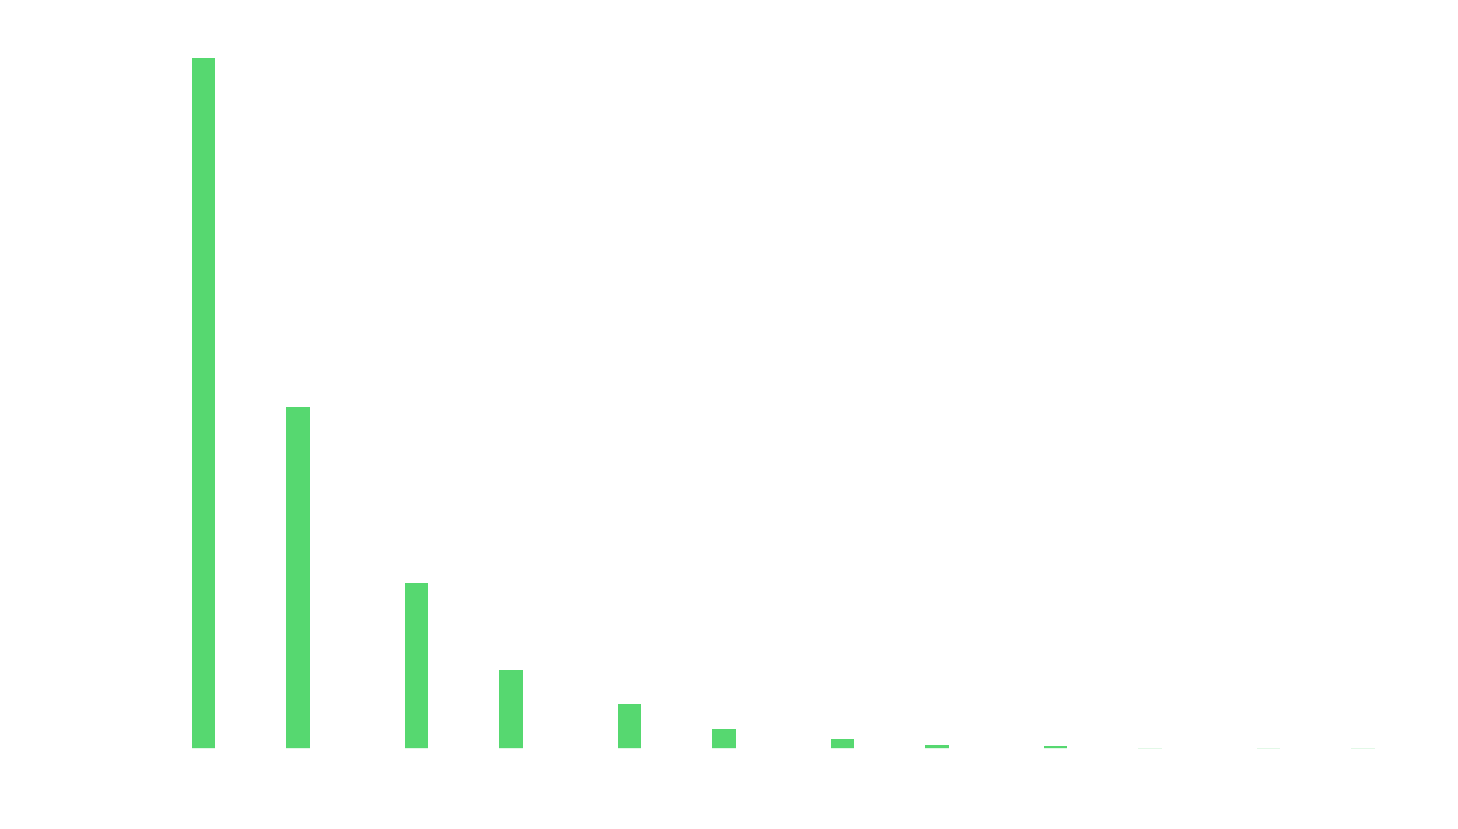

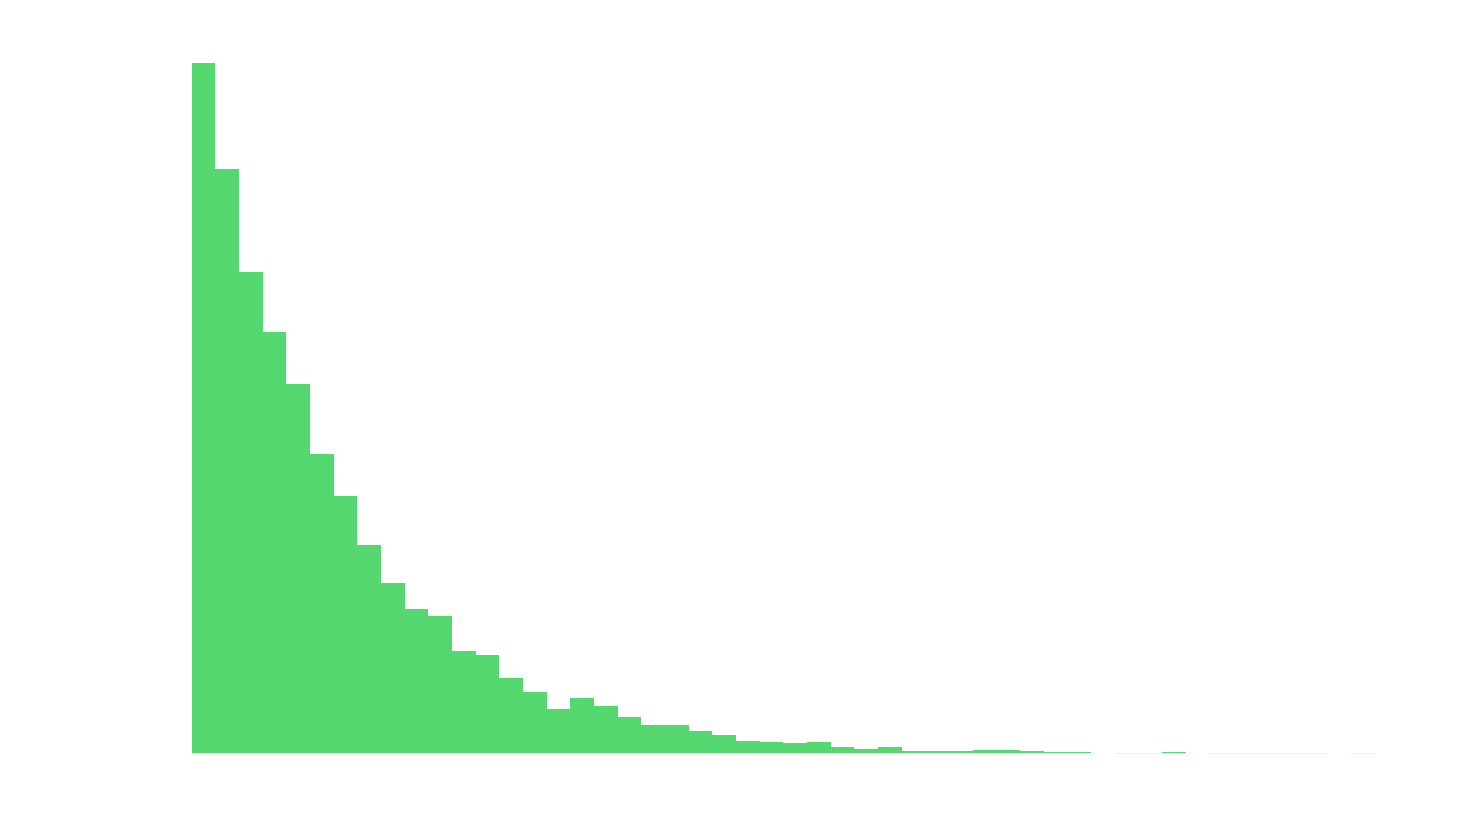

In [194]:
from scipy.stats import geom, expon
geom_distrib=geom(0.5).rvs(10000, random_state=42)
expon_distrib=expon(scale=1).rvs(10000, random_state=42)
plt.hist(geom_distrib, bins=50)
plt.show()
plt.hist(expon_distrib, bins=50)
plt.show()

## Exercises

In [195]:
from sklearn.model_selection import GridSearchCV

param_grid = [
        {'kernel': ['linear'], 'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
        {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],
         'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
    ]

svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=4)
grid_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  9.9min
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed: 16.1min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=4,
             param_grid=[{'C': [10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0,
                                10000.0, 30000.0],
                          'kernel': ['linear']},
                         {'C': [1.0, 3.0, 10.0, 30.0, 100.0, 300.0, 1000.0],
                          'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0],
                          'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=2)

In [196]:
negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

70363.84006944533

In [197]:
grid_search.best_params_

{'C': 30000.0, 'kernel': 'linear'}

In [ ]:
# The linear kernel seems better than the RBF kernel. Notice that the value of C is
# the maximum tested value. When this happens you definitely want to launch the grid
# search again with higher values for C (removing the smallest values), because it is
# likely that higher values of C will be better.

In [198]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

param_distribs = {
    'kernel': ['linear', 'rbf'],
    'C': reciprocal(20, 200000),
    'gamma': expon(scale=1.0)
}

svm_reg = SVR()
rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                               n_iter=50, cv=5, scoring='neg_mean_squared_error',
                               verbose=2, n_jobs=4, random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 15.0min
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed: 23.5min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='scale', kernel='rbf',
                                 max_iter=-1, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='deprecated', n_iter=50, n_jobs=4,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002019CD156D0>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002019CCCD820>,
                                        'kernel': ['linear', 'rbf']},
                   pre_dispatch='2*n_jobs', random_state=42, refit=True,
                   return_train_score=False, scoring='neg_mean_squared_error',
                   verbose=2)

In [199]:
negative_mse = rnd_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse


54767.960710084146

In [243]:
rnd_search.best_params_

{'C': 157055.10989448498, 'gamma': 0.26497040005002437, 'kernel': 'rbf'}

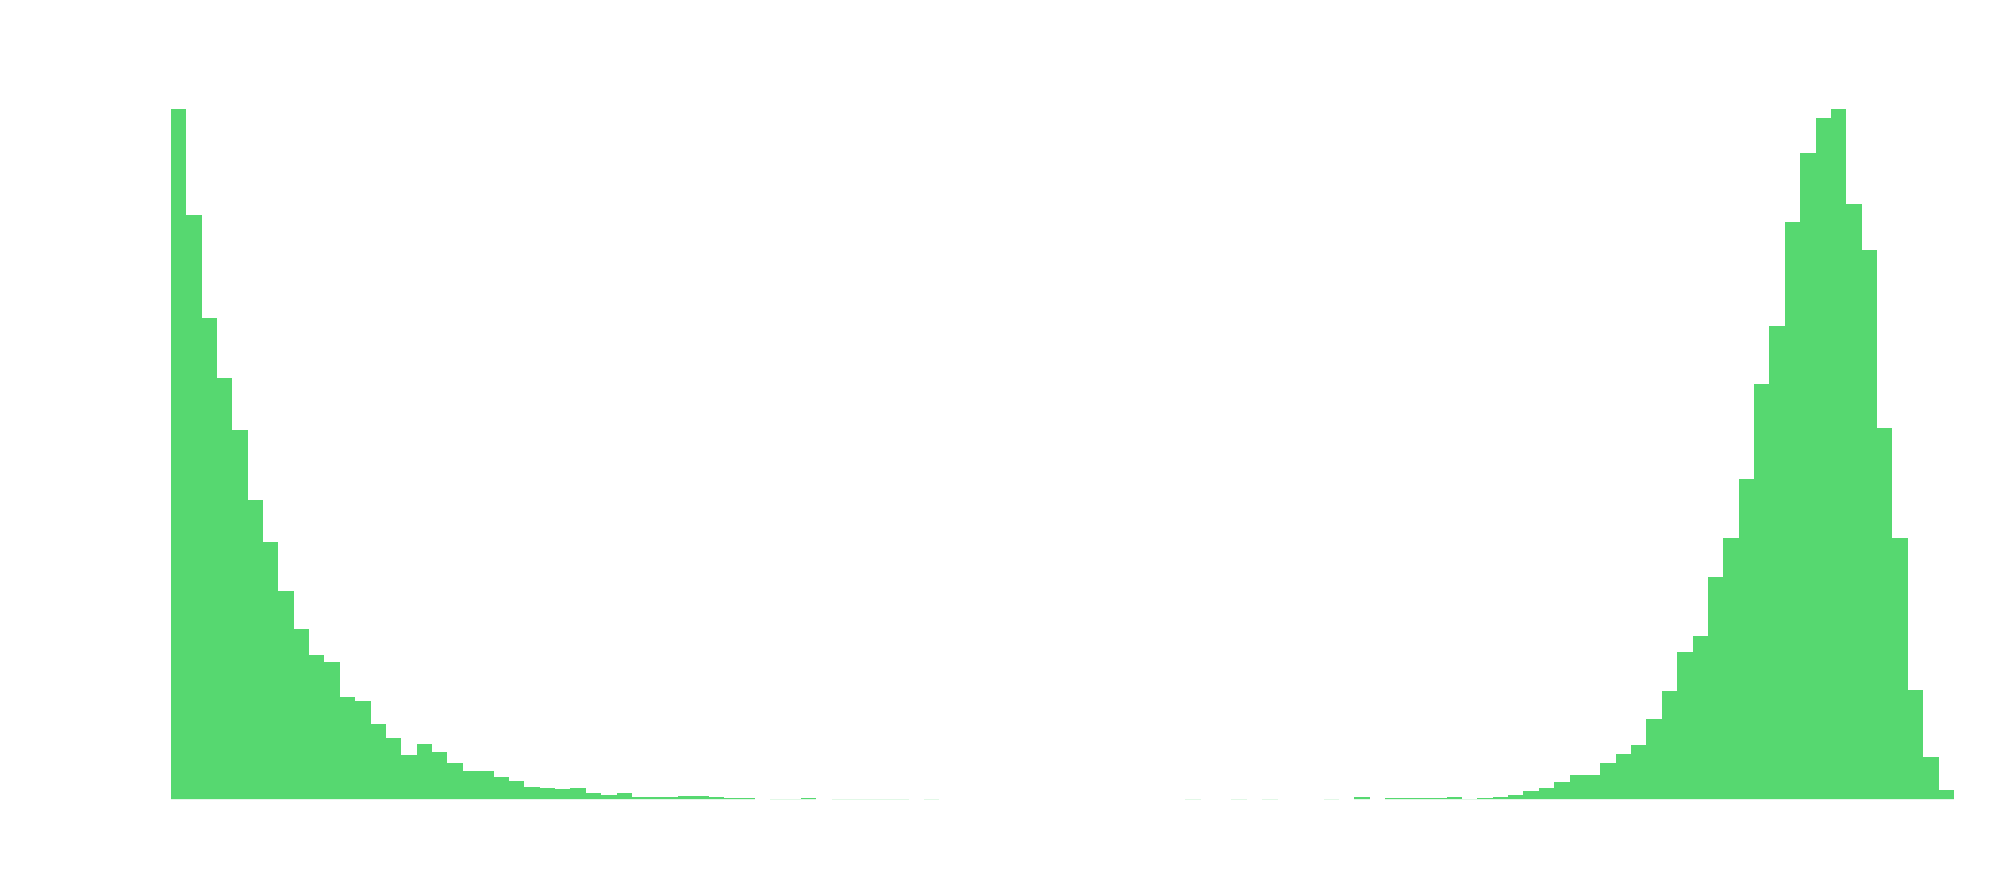

In [202]:
expon_distrib = expon(scale=1.)
samples = expon_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.title('Exponential distribution (scale=1.0)')
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title('Log of this distribution')
plt.hist(np.log(samples), bins=50)
plt.show()

In [ ]:
# The distribution we used for C looks quite different: the scale of the samples is picked
# from a uniform distribution within a given range, which is why the right graph, which
# represents the log of the samples, looks roughly constant. This distribution is useful
# when you don't have a clue of what the target scale is:

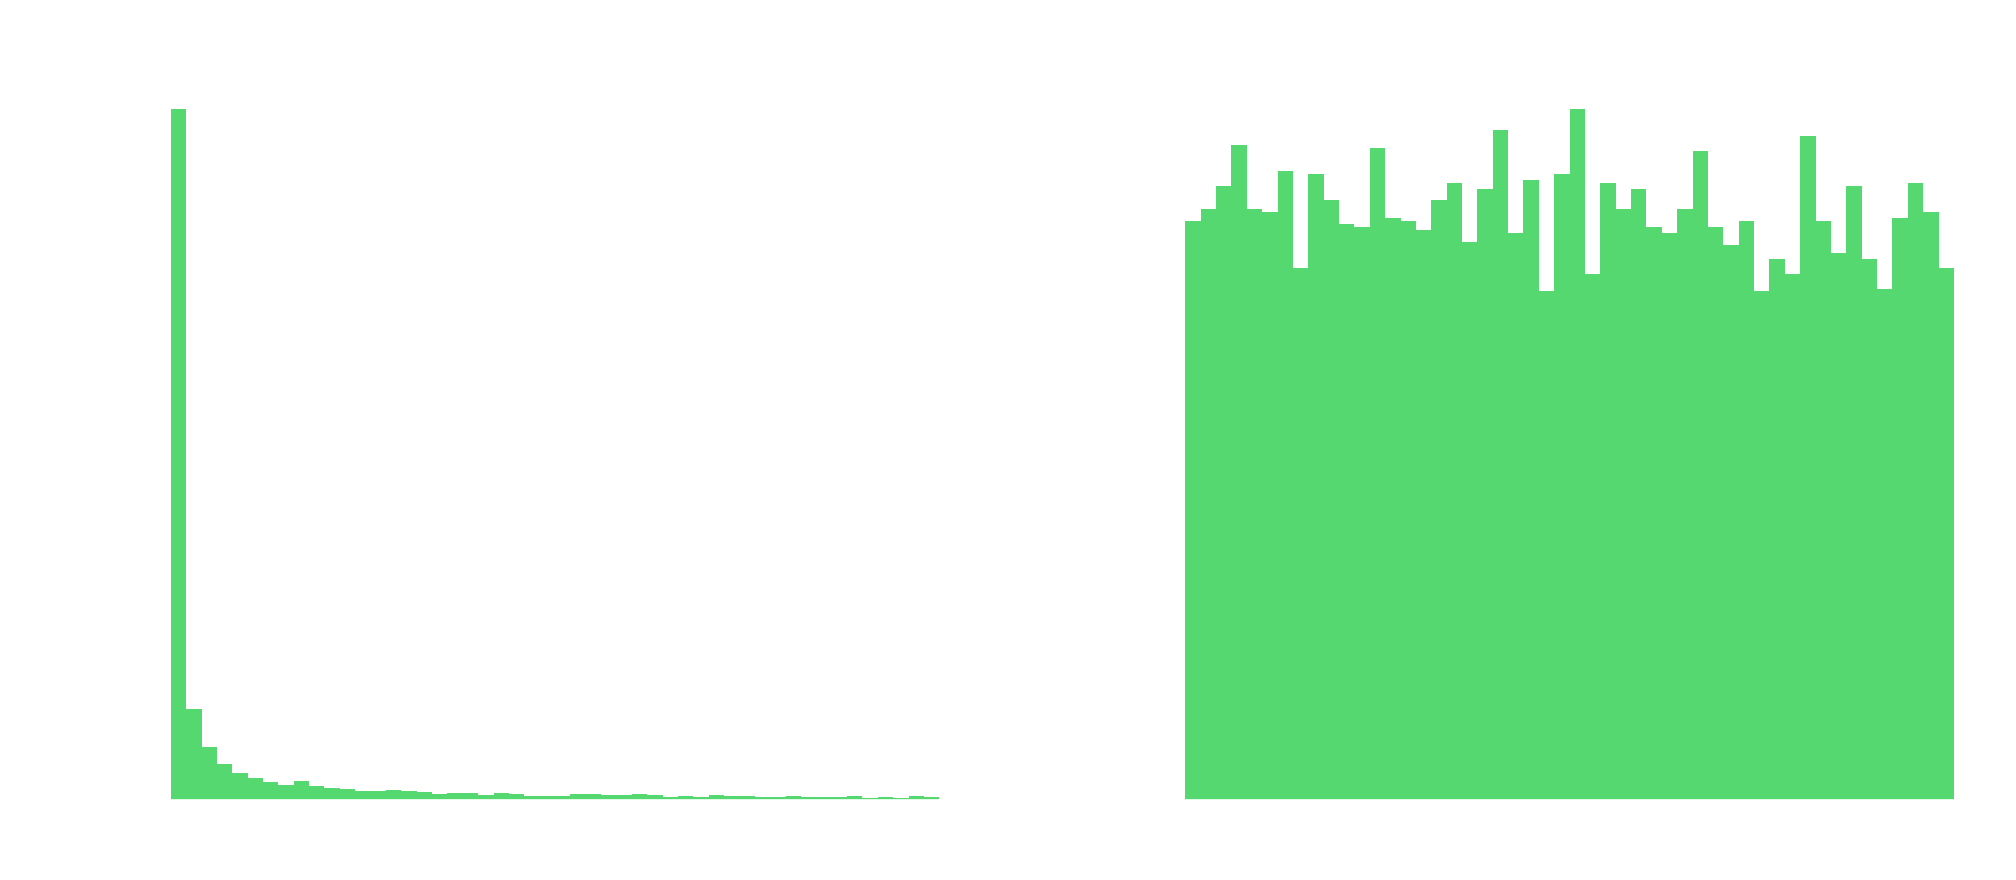

In [203]:
reciprocal_distrib = reciprocal(20, 200000)
samples = reciprocal_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title('Reciprocal distribution (scale=1.0)')
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

In [ ]:
# The reciprocal distribution is useful when you have no idea what the scale of the hyperparameter
# should be (indeed, as you can see on the figure on the right, all scales are equally likely, within
# the given range), whereas the exponential distribution is best when you know (more or less)
# what the scale of the hyperparameter should be.

In [228]:
# A transformer in the preparation pipeline to select only the most important attributes.
from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return X[:, self.feature_indices_]

In [229]:
k = 5
top_k_feature_indices = indices_of_top_k(feature_importances, k)
top_k_feature_indices
np.array(attributes)[top_k_feature_indices]


array(['longitude', 'latitude', 'median_income', 'pop_per_hhold',
       'INLAND'], dtype='<U18')

In [230]:
#checking that we are accessing the right top features
sorted(zip(feature_importances, attributes), reverse=True)[:k]

[(0.3758517768106295, 'median_income'),
 (0.1564619225304227, 'INLAND'),
 (0.11279565527825669, 'pop_per_hhold'),
 (0.07094918736798217, 'longitude'),
 (0.06760536013570752, 'latitude')]

In [231]:
# Pipeline with only the most important features
preparation_and_feature_selection_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k))
])

In [232]:
housing_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(housing)

# features of the first 3 instances
housing_prepared_top_k_features[0:3]

array([[-1.15604281,  0.77194962, -0.61493744, -0.08649871,  0.        ],
       [-1.17602483,  0.6596948 ,  1.33645936, -0.03353391,  0.        ],
       [ 1.18684903, -1.34218285, -0.5320456 , -0.09240499,  0.        ]])

In [233]:
housing_prepared[0:3, top_k_feature_indices]


array([[-1.15604281,  0.77194962, -0.61493744, -0.08649871,  0.        ],
       [-1.17602483,  0.6596948 ,  1.33645936, -0.03353391,  0.        ],
       [ 1.18684903, -1.34218285, -0.5320456 , -0.09240499,  0.        ]])

**Pipeline that does the full data preparation plus the final prediction**

In [257]:
best = rnd_search.best_params_

In [258]:
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k)),
    ('svm_reg', SVR(**rnd_search.best_params_))
])

In [260]:
prepare_select_and_predict_pipeline.fit(housing, housing_labels)

Pipeline(memory=None,
         steps=[('preparation',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                              

In [261]:
some_data = housing.iloc[:4]
some_labels = housing_labels.iloc[:4]

print("Predictions:\t", prepare_select_and_predict_pipeline.predict(some_data))
print("Labels:\t\t", list(some_labels))

Predictions:	 [203214.28978849 371846.88152572 173295.65441612  47328.3970888 ]
Labels:		 [286600.0, 340600.0, 196900.0, 46300.0]


### Preparation option

In [263]:
param_grid = [{
    'preparation__num__imputer__strategy': ['mean', 'median', 'most_frequent'],
    'feature_selection__k': list(range(1, len(feature_importances) + 1))
}]

grid_search_prep = GridSearchCV(prepare_select_and_predict_pipeline, param_grid, cv=5,
                                scoring='neg_mean_squared_error', verbose=2, n_jobs=4)
grid_search_prep.fit(housing, housing_labels)


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  7.8min
[Parallel(n_jobs=4)]: Done 240 out of 240 | elapsed: 18.9min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preparation',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                                     

In [264]:
grid_search_prep.best_params_

{'feature_selection__k': 15,
 'preparation__num__imputer__strategy': 'most_frequent'}